### Carga de librerías necesarias para ETL

In [54]:
import glob
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

### Extracción

In [55]:
# Probablemente se debería arrancar descomprimiendo el archivo: Clou_diario_diplo.rar

### Carga de datasets
Consumos:

In [56]:
# Son archivos mensuales CSV con ; como separador
archivos_cargados=[]

# Construccion del dataframe
consumos= pd.DataFrame()

# Carga de las lectoras mensuales de consumos
for each_file in glob.glob('*FINAL.csv'):
    archivos_cargados.append(each_file)
    datos_mes = pd.read_csv(each_file, sep=";", decimal=',')
    consumos = pd.concat([consumos, datos_mes])

Contratos:

In [57]:
# Es un archivo CSV con ; como separador
qgis = pd.read_csv('QGIS_final.csv', sep=";", decimal=',')

Clima:

In [58]:
# Es un archivo de texto de ancho fijo
col_widths = [8, 6, 6, 40]

# Columnas
column_names = ['FECHA', 'TMAX', 'TMIN', 'NOMBRE']

# Archivo
file_path = 'clima.txt'

# Carga
clima = pd.read_fwf(file_path, widths=col_widths, names=column_names, header=None)

# Me quedo solo con mediciones de Cordoba
clima = clima.loc[clima['NOMBRE'].str.contains('CORDOBA')]

Observario:

In [59]:
# Es un archivo de texto con múltiples datos las precipitaciones contienen además comentarios
precipitaciones = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=5, nrows=31)

# Se elimina columna sin datos creada automáticamente
precipitaciones.drop('Unnamed: 13', axis=1, inplace=True)

In [60]:
# Es un archivo de texto con múltiples datos las temperaturas contienen además comentarios
temperatura_max = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=44, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_max.drop('Unnamed: 13', axis=1, inplace=True)

In [61]:
# Es un archivo de texto con múltiples datos las temperaturas contienen además comentarios
temperatura_min = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=82, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_min.drop('Unnamed: 13', axis=1, inplace=True)

In [62]:
# Es un archivo de texto con múltiples datos las temperaturas contienen además comentarios
temperatura_avg = pd.read_csv('CORDOBA OBSERVATORIO.txt', sep=";", decimal=',', encoding ='latin1', skiprows=120, nrows=31)

# Se elimina columna sin datos creada automáticamente
temperatura_avg.drop('Unnamed: 13', axis=1, inplace=True)

### Observación inicial de los datos disponibles

In [63]:
consumos.head()

,DEVICE,TV,UPDATE_TV,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,...,VALUE18,VALUE19,VALUE20,VALUE21,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,RN
0,0,01/03/2023,01/03/2023,NaN,1923.249,1923.249,986.267,476.932,460.050,0.0,...,0.0,0.976,2023-02-12 16:15:00,NaN,NaN,NaN,NaN,NaN,NaN,436592.0
1,0,02/03/2023,02/03/2023,NaN,1926.942,1926.942,988.037,477.729,461.176,0.0,...,0.0,0.448,2023-03-01 05:45:00,NaN,NaN,NaN,NaN,NaN,NaN,157145.0
2,0,03/03/2023,03/03/2023,NaN,1931.674,1931.674,990.627,478.887,462.160,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,336137.0
3,0,04/03/2023,04/03/2023,NaN,1935.935,1935.935,992.869,479.820,463.246,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,411506.0
4,0,05/03/2023,05/03/2023,NaN,1939.996,1939.996,994.944,480.914,464.138,0.0,...,0.0,0.732,2023-03-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,369475.0


In [64]:
qgis.head()

,DEVICE,suministro,cliente,contrato,fecha_inicio,sea,distribuidor,subestacion,zona,distrito,distrito_descripcion,grupo_lectura,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa,tarifa
0,0,01_AA01,LZKVIR,3,2010-06-08Z,DBOSCO,13_ACHATEAU,5282.0,A,1,CORDOBA,1,1223,168,1,190,Residencial
1,1,01_AA02,EVLNRMZ,5,2014-05-06Z,DBOSCO,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,90,1,140,1.a/f RESIDENCIAL
2,2,01_AA03,RXXDNSQ,4,2023-10-25Z,DBOSCO,13_ACHATEAU,5076.0,A,1,CORDOBA,1,1223,414,1,140,1.a/f RESIDENCIAL
3,3,01_AA04,ZTHSMEW,2,2022-08-17Z,NaN,13_ACHATEAU,5311.0,A,1,CORDOBA,1,1223,6,1,140,1.a/f RESIDENCIAL
4,4,01_AA05,IELVEK,1,1990-06-30Z,DFUNES,13_CARAFA,1685.0,A,1,CORDOBA,3,1261,37,1,140,1.a/f RESIDENCIAL


In [65]:
clima.head()

,FECHA,TMAX,TMIN,NOMBRE
26,10062024,20.5,5.3,CORDOBA AERO
27,10062024,21.5,7.6,CORDOBA OBSERVATORIO
145,09062024,26.4,11.0,CORDOBA AERO
146,09062024,25.5,14.2,CORDOBA OBSERVATORIO
264,08062024,24.8,13.0,CORDOBA AERO


In [66]:
temperatura_avg.head()

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,22.6,"25,6",26.7,"18,9",16.6,"16,7",13.3,23.4,"19,5",20.6,"10,1",26.0
1,2,24.5,"22,2",27.9,"18,8",16.4,"20,5",20.8,20.5,"14,1",22.4,"11,3",26.4
2,3,24.5,"23,8",27.6,"20,8",15.4,"18,5",19.2,16.3,"10,5",17.5,"15,0",16.2
3,4,26.1,"23,5",28.2,"20,8",15.2,"15,7",22.1,14.6,"12,8",16.1,"20,0",15.8
4,5,27.5,"25,8",29.3,"20,8",14.7,"16,3",17.0,16.9,"12,0",19.0,"22,2",16.5


In [67]:
print('consumos: ', consumos.shape, ' contratos:', qgis.shape, ' clima:', clima.shape, ' precipitaciones:', precipitaciones.shape, ' temperatura:',temperatura_min.shape, temperatura_avg.shape, temperatura_max.shape)

consumos:  (1717933, 30)  contratos: (4751, 17)  clima: (730, 4)  precipitaciones: (31, 13)  temperatura: (31, 13) (31, 13) (31, 13)


### Limpieza y preparación de los datasets

#### Consumos

In [68]:
# Renombro columnas (de acuerdo las instrucciones recibidas)
consumos = consumos.rename(columns={'VALUE2': 'Energia_Siempre_Positiva', 'VALUE3': 'Energia_Directa', 'VALUE4': 'Energia_Directa_Resto',
                                    'VALUE5': 'Energia_Directa_Pico', 'VALUE6': 'Energia_Directa_Valle', 'VALUE7': 'Energia_Inversa', 
                                    'VALUE8': 'Energia_Inversa_Resto', 'VALUE9': 'Energia_Inversa_Pico', 
                                    'VALUE10': 'Energia_Inversa_Valle', 'VALUE19': 'Maxima_Demanda', 'VALUE20': 'Fecha_hora'})

Verificación inicial de datos faltantes:

In [69]:
(round(consumos.isna().sum() * 100 / consumos.shape[0], 2)).astype(str) + "%"

DEVICE                        0.0%
TV                            0.0%
UPDATE_TV                     0.0%
VALUE1                      100.0%
Energia_Siempre_Positiva      0.0%
Energia_Directa               0.0%
Energia_Directa_Resto         0.0%
Energia_Directa_Pico          0.0%
Energia_Directa_Valle         0.0%
Energia_Inversa               0.0%
Energia_Inversa_Resto         0.0%
Energia_Inversa_Pico          0.0%
Energia_Inversa_Valle         0.0%
VALUE11                       0.0%
VALUE12                       0.0%
VALUE13                       0.0%
VALUE14                       0.0%
VALUE15                       0.0%
VALUE16                       0.0%
VALUE17                       0.0%
VALUE18                       0.0%
Maxima_Demanda                0.0%
Fecha_hora                    0.0%
VALUE21                     99.97%
VALUE22                     99.97%
VALUE23                     99.97%
VALUE24                     99.97%
VALUE25                     99.97%
VALUE26             

In [70]:
# Umbral para eliminar columnas sin datos 
umbral = 90 # (90% en este caso)

for column in consumos.columns:
    # Calculando el porcentaje de valores no nulos en la columna
    porcentaje = consumos[column].count() / len(consumos) * 100
    
    # Si es menor al umbral
    if porcentaje < umbral:
        # eliminamos columna
        consumos.drop(column, axis=1, inplace=True)

In [71]:
consumos['UPDATE_TV'] = pd.to_datetime(consumos['UPDATE_TV'], format='%d/%m/%Y') 

In [72]:
consumos['TV'] = pd.to_datetime(consumos['TV'], format='%d/%m/%Y') 

existen valores erroneos en 'Fecha_hora':

In [73]:
consumos.loc[consumos['Fecha_hora']=='FFFF-FF-FF  FF:FF:FF'].head()

,DEVICE,TV,UPDATE_TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Energia_Inversa,Energia_Inversa_Resto,...,VALUE12,VALUE13,VALUE14,VALUE15,VALUE16,VALUE17,VALUE18,Maxima_Demanda,Fecha_hora,RN
311,10,2023-03-02,2023-03-02,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,86979.0
312,10,2023-03-03,2023-03-03,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,336694.0
313,10,2023-03-04,2023-03-04,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,98374.0
314,10,2023-03-05,2023-03-05,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,1611.0
315,10,2023-03-06,2023-03-06,2.056,2.056,1.367,0.409,0.28,0.0,0.0,...,1.744,0.395,0.482,0.0,0.0,0.0,0.0,0.0,FFFF-FF-FF FF:FF:FF,381975.0


corrección de valores erroneos con ffill

In [74]:
consumos['Fecha_hora'] = pd.to_datetime(consumos['Fecha_hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce').ffill()

#### Contratos

In [75]:
(round(qgis.isna().sum() * 100 / qgis.shape[0], 2)).astype(str) + "%"

DEVICE                   0.0%
suministro               0.0%
cliente                  0.0%
contrato                 0.0%
fecha_inicio             0.0%
sea                     0.76%
distribuidor             0.0%
subestacion             0.15%
zona                     0.0%
distrito                 0.0%
distrito_descripcion     0.0%
grupo_lectura           0.02%
ruta_lectura             0.0%
orden_lectura            0.0%
grupo_tarifario          0.0%
codigo_tarifa            0.0%
tarifa                   0.0%
dtype: object

Validación de los campos fecha:

In [76]:
qgis['fecha_inicio'] = pd.to_datetime(qgis['fecha_inicio'].replace('Z','', regex=True), format='%Y-%m-%d') 

#### Clima

In [77]:
clima['FECHA'] = pd.to_datetime(clima['FECHA'], format='%d%m%Y') 

#### Precipitaciones

Asignación de valores en las precipitaciones:

In [78]:
# S/P equivale a "no llovió", <0.1 equivale a 0.1
precipitaciones = precipitaciones.replace('S/P',0).replace('<0.1',0.1).replace(',','.', regex=True)

In [79]:
precipitaciones.apply(pd.to_numeric)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,3.0,22.5,0.1,0.1,0.0,0.0,0.0,0,0.0,0.0,10.0,0.6
1,2,0.0,0.0,0.0,2.0,0.1,0.0,0.0,0,3.0,0.0,0.0,1.0
2,3,1.0,0.0,0.0,0.0,0.1,0.1,0.0,0,0.2,0.0,0.0,3.0
3,4,0.0,0.0,0.0,0.1,9.0,0.1,0.0,0,0.0,0.0,0.0,4.0
4,5,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0.0,0.0,4.0
5,6,0.0,0.0,22.0,0.0,0.0,0.0,0.1,0,2.0,0.0,0.0,0.2
6,7,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,0.0,0.0,0.0,0.0
9,10,9.5,0.0,0.0,0.0,0.0,0.0,9.5,0,0.0,0.0,0.0,0.0


#### Temperaturas

In [80]:
temperatura_min = temperatura_min.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_avg = temperatura_avg.replace('s/d',np.NaN).replace(',','.', regex=True)
temperatura_max = temperatura_max.replace('s/d',np.NaN).replace(',','.', regex=True)

In [81]:
temperatura_min.apply(pd.to_numeric)
temperatura_avg.apply(pd.to_numeric)
temperatura_max.apply(pd.to_numeric)

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,30.1,30.2,33.0,24.7,20.0,24.8,23.1,34.5,28.6,29.0,12.5,35.0
1,2,32.1,28.2,37.8,20.6,20.5,27.4,27.6,30.0,23.6,30.1,14.4,33.0
2,3,31.5,29.0,35.2,26.6,19.2,24.3,25.5,21.5,13.6,24.4,24.5,27.6
3,4,33.5,29.0,37.5,24.7,18.4,19.2,30.1,23.3,17.4,23.4,27.5,18.3
4,5,35.5,32.6,37.2,25.4,16.5,21.6,20.5,23.0,17.4,27.7,30.5,19.5
5,6,36.7,35.3,35.5,28.3,21.7,26.2,16.0,26.0,16.2,29.6,33.8,28.4
6,7,38.2,36.7,32.1,29.4,26.4,21.5,14.5,18.7,20.4,28.2,43.7,32.5
7,8,37.8,32.7,36.2,29.8,24.8,29.6,20.8,17.0,18.8,31.2,30.3,30.0
8,9,38.2,34.5,36.2,30.4,27.5,23.2,16.8,19.7,24.2,32.6,29.6,27.4
9,10,39.5,35.2,37.4,30.6,23.4,14.9,15.8,26.0,35.0,38.5,29.5,32.8


### Diccionario de datos

#### Consumos
* DEVICE = MEDIDOR
* TV = EL MOMENTO EN QUE SE REALIZA LA MEDICIÓN
* UPDATE_TV = ES CUANDO SE GUARDA EL REGISTRO DE LA MEDICIÓN
* Energía inversa: son  aquellos usuarios que generan electricidad y aportan a la red de distribución.

#### QGIS
* DEVICE = MEDIDOR
* Suministro = número de medidor (innominado)
* Cliente = nombre de cliente (innominado)
* Contrato = cuantas veces fue contratado el servicio por diferentes personas
* Distribuidor = Cable de media tensión que se utiliza
* Subestación = subestación transformadora

### Carga de librerías necesarias para Análisis exploratorio

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
print('Dataset tiene filas y columnas: ', consumos.shape, '\n')
print('Nombre columnas del dataset: ', '\n', consumos.columns, '\n')
print('Tipo de dato de cada columna: ', '\n', consumos.dtypes , '\n')
print('Descripción estadística: ', '\n', consumos.describe(), '\n')

Dataset tiene filas y columnas:  (1717933, 23) 

Nombre columnas del dataset:  
 Index(['DEVICE', 'TV', 'UPDATE_TV', 'Energia_Siempre_Positiva',
       'Energia_Directa', 'Energia_Directa_Resto', 'Energia_Directa_Pico',
       'Energia_Directa_Valle', 'Energia_Inversa', 'Energia_Inversa_Resto',
       'Energia_Inversa_Pico', 'Energia_Inversa_Valle', 'VALUE11', 'VALUE12',
       'VALUE13', 'VALUE14', 'VALUE15', 'VALUE16', 'VALUE17', 'VALUE18',
       'Maxima_Demanda', 'Fecha_hora', 'RN'],
      dtype='object') 

Tipo de dato de cada columna:  
 DEVICE                               int64
TV                          datetime64[ns]
UPDATE_TV                   datetime64[ns]
Energia_Siempre_Positiva           float64
Energia_Directa                    float64
Energia_Directa_Resto              float64
Energia_Directa_Pico               float64
Energia_Directa_Valle              float64
Energia_Inversa                    float64
Energia_Inversa_Resto              float64
Energia_Inversa_Pico

In [90]:
# Gráfico de distribución para cada variable
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(12, 18))
axes = axes.flat
numeric_features = consumos.select_dtypes(include=['float64', 'int64']).columns.tolist()

for i, colum in enumerate(numeric_features):
    sns.histplot(
        data    = consumos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables en los consumos', fontsize = 10, fontweight = "bold");

In [ ]:
consumos.corr()

,DEVICE,TV,UPDATE_TV,Energia_Siempre_Positiva,Energia_Directa,Energia_Directa_Resto,Energia_Directa_Pico,Energia_Directa_Valle,Energia_Inversa,Energia_Inversa_Resto,...,VALUE12,VALUE13,VALUE14,VALUE15,VALUE16,VALUE17,VALUE18,Maxima_Demanda,Fecha_hora,RN
DEVICE,1.000000,0.000512,0.000492,0.150116,0.150151,0.154126,0.138148,0.122323,0.007894,0.003555,...,0.126576,0.106883,0.095091,0.018195,0.023329,0.009200,0.011007,0.203114,-0.000009,0.001238
TV,0.000512,1.000000,0.999984,0.104370,0.104345,0.097176,0.108853,0.095811,0.006944,0.006711,...,0.075114,0.073618,0.078959,0.007909,0.008256,0.006701,0.006941,-0.021458,0.706600,0.028653
UPDATE_TV,0.000492,0.999984,1.000000,0.104441,0.104416,0.097302,0.108846,0.095813,0.006936,0.006703,...,0.075330,0.073609,0.078953,0.007902,0.008248,0.006697,0.006936,-0.021291,0.706603,0.028728
Energia_Siempre_Positiva,0.150116,0.104370,0.104441,1.000000,0.999424,0.968496,0.959001,0.912564,0.076202,0.068790,...,0.736045,0.724704,0.709058,0.073166,0.079742,0.047803,0.069810,0.688432,0.070797,0.002679
Energia_Directa,0.150151,0.104345,0.104416,0.999424,1.000000,0.969047,0.959770,0.912884,0.042315,0.035676,...,0.737017,0.725730,0.710021,0.048527,0.053982,0.026805,0.048415,0.687916,0.070786,0.002700
Energia_Directa_Resto,0.154126,0.097176,0.097302,0.968496,0.969047,1.000000,0.875016,0.793733,0.041223,0.034413,...,0.780252,0.692928,0.656382,0.042492,0.046813,0.027644,0.039359,0.717712,0.065831,0.002388
Energia_Directa_Pico,0.138148,0.108853,0.108846,0.959001,0.959770,0.875016,1.000000,0.928165,0.034242,0.029044,...,0.671338,0.748555,0.728029,0.050681,0.057636,0.019137,0.056261,0.624994,0.074978,0.002872
Energia_Directa_Valle,0.122323,0.095811,0.095813,0.912564,0.912884,0.793733,0.928165,1.000000,0.044681,0.038319,...,0.549908,0.633832,0.676816,0.051046,0.056593,0.027233,0.052400,0.540542,0.064050,0.002730
Energia_Inversa,0.007894,0.006944,0.006936,0.076202,0.042315,0.041223,0.034242,0.044681,1.000000,0.976876,...,0.015070,0.012818,0.013736,0.728171,0.761455,0.619671,0.632673,0.055964,0.004501,-0.000474
Energia_Inversa_Resto,0.003555,0.006711,0.006703,0.068790,0.035676,0.034413,0.029044,0.038319,0.976876,1.000000,...,0.011795,0.010375,0.011235,0.648284,0.697599,0.527087,0.537103,0.050023,0.004311,-0.000323


In [ ]:
print('Dataset tiene filas y columnas: ', qgis.shape, '\n')
print('Nombre columnas del dataset: ', '\n', qgis.columns, '\n')
print('Tipo de dato de cada columna: ', '\n', qgis.dtypes , '\n')
print('Descripción estadística: ', '\n', qgis.describe(), '\n')

Dataset tiene filas y columnas:  (4751, 17) 

Nombre columnas del dataset:  
 Index(['DEVICE', 'suministro', 'cliente', 'contrato', 'fecha_inicio', 'sea',
       'distribuidor', 'subestacion', 'zona', 'distrito',
       'distrito_descripcion', 'grupo_lectura', 'ruta_lectura',
       'orden_lectura', 'grupo_tarifario', 'codigo_tarifa', 'tarifa'],
      dtype='object') 

Tipo de dato de cada columna:  
 DEVICE                           int64
suministro                      object
cliente                         object
contrato                         int64
fecha_inicio            datetime64[ns]
sea                             object
distribuidor                    object
subestacion                    float64
zona                            object
distrito                         int64
distrito_descripcion            object
grupo_lectura                   object
ruta_lectura                     int64
orden_lectura                    int64
grupo_tarifario                  int64
codigo_tar

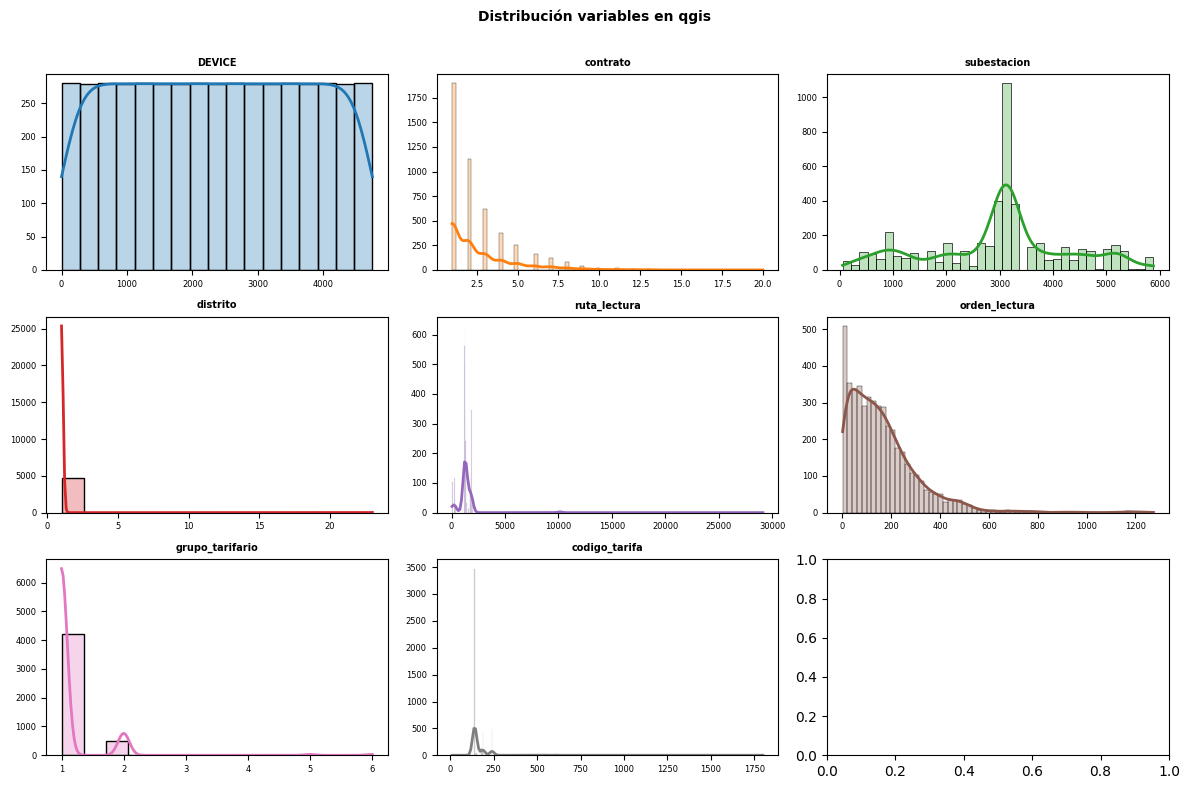

In [ ]:
# Gráfico de distribución para cada variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flat
numeric_features = qgis.select_dtypes(include=['float64', 'int64']).columns.tolist()

for i, colum in enumerate(numeric_features):
    sns.histplot(
        data    = qgis,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables en qgis', fontsize = 10, fontweight = "bold");

In [ ]:
qgis[numeric_features].corr()

,DEVICE,contrato,subestacion,distrito,ruta_lectura,orden_lectura,grupo_tarifario,codigo_tarifa
DEVICE,1.000000,-0.112211,-0.019821,0.019816,0.085053,0.106779,0.154878,0.123834
contrato,-0.112211,1.000000,-0.048702,0.001891,-0.034872,0.005270,0.042537,0.000476
subestacion,-0.019821,-0.048702,1.000000,0.031941,-0.028149,0.032484,0.036674,0.015681
distrito,0.019816,0.001891,0.031941,1.000000,0.134901,-0.013262,0.006257,0.006290
ruta_lectura,0.085053,-0.034872,-0.028149,0.134901,1.000000,-0.061498,0.504838,0.332511
orden_lectura,0.106779,0.005270,0.032484,-0.013262,-0.061498,1.000000,-0.056272,-0.040088
grupo_tarifario,0.154878,0.042537,0.036674,0.006257,0.504838,-0.056272,1.000000,0.676625
codigo_tarifa,0.123834,0.000476,0.015681,0.006290,0.332511,-0.040088,0.676625,1.000000
